In [18]:
# Import required libraries

import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from matplotlib import pyplot as plt
from joblib import dump



In [19]:
# Load dataset and preprocess
dataset_path = '../../Dataset/data_merged.csv'
data = pd.read_csv(dataset_path)



In [20]:
# Define popularity threshold and discretize
popularity_threshold = 42
data["popularity_label"] = data["popularity"].apply(lambda x: 1 if x >= popularity_threshold else 0)



In [21]:
# Split features and target variable
X = data.drop(["popularity", "popularity_label"], axis=1)
y = data["popularity_label"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=21
)



In [22]:
# Initialize XGBoost Classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')



In [23]:
# Train the model with default parameters
xgb_clf.fit(X_train, y_train)



c:\Users\Neil\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:38:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [24]:
# Evaluate model on training set
y_train_pred = xgb_clf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy}")



Training Accuracy: 0.9138796957556755


In [25]:
# Evaluate model on test set
y_test_pred = xgb_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Testing Accuracy: {test_accuracy}")



Testing Accuracy: 0.8913661963653254


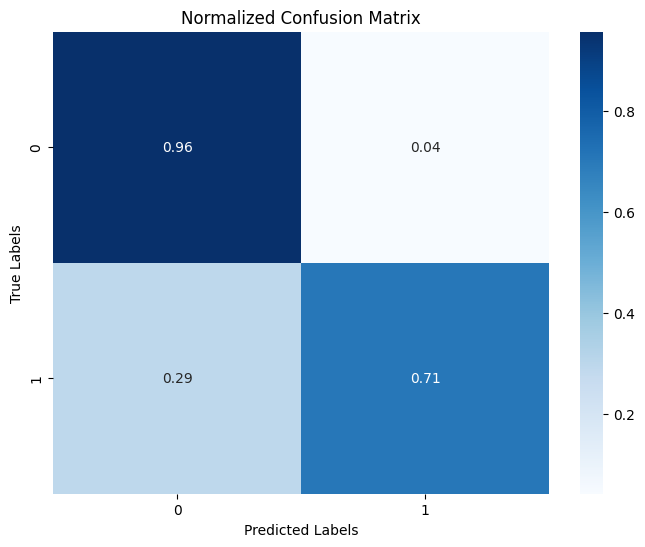

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     25426
           1       0.85      0.71      0.77      9020

    accuracy                           0.89     34446
   macro avg       0.88      0.83      0.85     34446
weighted avg       0.89      0.89      0.89     34446



In [28]:
# Print confusion matrix and classification report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_test_pred)

# Normalize the confusion matrix
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
print(f"Classification Report:\n{classification_report(y_test, y_test_pred)}")



In [12]:
# Bayesian Optimization for Hyperparameter Tuning
opt = BayesSearchCV(
    xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    {
        'n_estimators': Integer(50, 250),
        'learning_rate': Real(0.01, 1.0),
        'max_depth': Integer(3, 10),
        'subsample': Real(0.5, 1.0),
        'colsample_bytree': Real(0.5, 1.0),
    },
    n_iter=32,
    cv=3,
    random_state=42
)

# Fit the model with Bayesian Optimization
opt.fit(X_train, y_train)



c:\Users\Neil\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:35:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


KeyboardInterrupt: 

In [ ]:
from joblib import dump
dump(opt, r"C:\Users\Neil\OneDrive\Desktop\song-popularity-prediction-master\models\XGBoost.joblib")

['C:\\Users\\Neil\\OneDrive\\Desktop\\song-popularity-prediction-master\\models\\XGBoost.joblib']

In [ ]:
# Display best parameters and scores
print(f"Best Parameters: {opt.best_params_}")
print(f"Validation Score: {opt.best_score_}")
print(f"Test Score: {opt.score(X_test, y_test)}")



Best Parameters: OrderedDict({'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 250, 'subsample': 1.0})
Validation Score: 0.8901614120652616
Test Score: 0.8914242582593044


In [ ]:
# Test the optimized model
y_optimized_pred = opt.predict(X_test)
print(f"Optimized Confusion Matrix:\n{confusion_matrix(y_test, y_optimized_pred)}")
print(f"Optimized Classification Report:\n{classification_report(y_test, y_optimized_pred)}")



Optimized Confusion Matrix:
[[24543   883]
 [ 2857  6163]]
Optimized Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93     25426
           1       0.87      0.68      0.77      9020

    accuracy                           0.89     34446
   macro avg       0.89      0.82      0.85     34446
weighted avg       0.89      0.89      0.89     34446



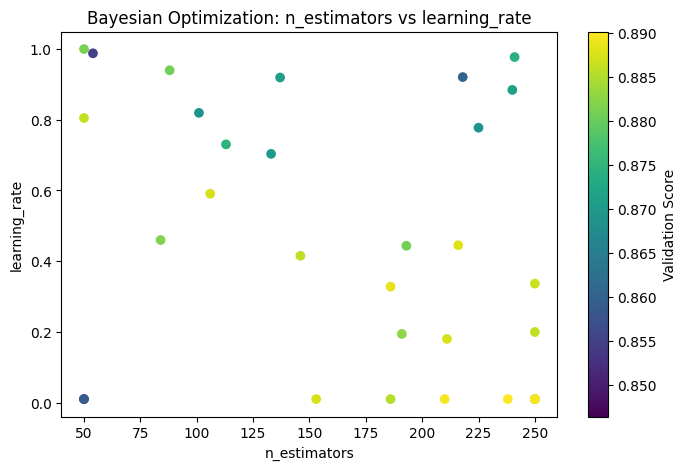

In [ ]:
# Visualize results
plt.figure(figsize=(8, 5))
plt.title("Bayesian Optimization: n_estimators vs learning_rate")
plt.scatter(
    [res['n_estimators'] for res in opt.cv_results_['params']],
    [res['learning_rate'] for res in opt.cv_results_['params']],
    c=opt.cv_results_['mean_test_score'],
    cmap='viridis'
)
plt.colorbar(label='Validation Score')
plt.xlabel('n_estimators')
plt.ylabel('learning_rate')
plt.show()